In [60]:
# ===== 1) Imports & Configuration =====
import os, glob, math, warnings
import numpy as np
import pandas as pd
import re
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score

# Try import XGBoost
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except ImportError:
    HAS_XGB = False
    print("XGBoost not installed. Will use RF/LR only.")

warnings.filterwarnings("ignore")

class CFG:
    # Adjust paths as needed
    train_dir = "../data/train"
    test_dir  = "../data/test"
    pair_hint = "EURUSD"

    # Execution Costs
    spread_pips: float = 1.0
    slippage_pips: float = 0.2
    commission_per_lot_usd: float = 0.0
    risk_per_trade: float = 0.01

    # Triple-Barrier & Tuning
    tp_atr: float = 2.0
    sl_atr: float = 1.5
    max_hold_bars: int = 16  # 4 hours on 15m

    # Validation Splitting
    core_end = "2021-12-31"
    val_end  = "2023-12-31"

cfg = CFG()

# ===== Helper Functions (Data Loading) =====
def _guess_tf_from_name(name: str) -> str:
    n = name.lower()
    # Check for m15, 15m, etc.
    if "m15" in n or "15m" in n: return "15m"
    if "h1" in n or "1h" in n: return "1h"
    if "h4" in n or "4h" in n: return "4h"
    if "m1" in n or "1m" in n: return "1m"
    return ""

def _pick_files(data_dir: str, pair_hint: str):
    if not os.path.exists(data_dir):
        # try stepping up
        if os.path.exists(os.path.join("..", data_dir)):
             data_dir = os.path.join("..", data_dir)
             
    files = glob.glob(os.path.join(data_dir, "*.csv")) + glob.glob(os.path.join(data_dir, "*.parquet"))
    if not files:
        # Check absolute path
        abs_path = os.path.abspath(data_dir)
        files = glob.glob(os.path.join(abs_path, "*.csv"))
        
    if not files:
        raise FileNotFoundError(f"No data inputs in {data_dir}. Parsed as {os.path.abspath(data_dir)}")

    hinted = [f for f in files if pair_hint.lower() in os.path.basename(f).lower()]
    if hinted: files = hinted
    
    by_tf = {}
    for f in files:
        tf = _guess_tf_from_name(os.path.basename(f))
        if tf and tf not in by_tf: by_tf[tf] = f
    return by_tf

def _standardize_ohlc(df: pd.DataFrame) -> pd.DataFrame:
    df.columns = [c.lower() for c in df.columns]
    rename_map = {}
    for c in df.columns:
        if "time" in c or "date" in c: rename_map[c] = "time"
        elif "open" in c: rename_map[c] = "open"
        elif "high" in c: rename_map[c] = "high"
        elif "low" in c: rename_map[c] = "low"
        elif "close" in c: rename_map[c] = "close"
        elif "vol" in c: rename_map[c] = "volume"
    df = df.rename(columns=rename_map)
    df["time"] = pd.to_datetime(df["time"], utc=True, errors='coerce')
    df = df.dropna(subset=["time"]).sort_values("time").set_index("time")
    # Force float
    cols = ["open","high","low","close","volume"]
    for c in cols:
        if c in df.columns:
            df[c] = df[c].astype(float)
    return df[ [c for c in cols if c in df.columns] ]

def load_tf(data_dir: str, pair_hint: str):
    by_tf = _pick_files(data_dir, pair_hint)
    out = {}
    for tf in ["1m","15m","1h","4h"]:
        if tf in by_tf:
            try:
                out[tf] = _standardize_ohlc(pd.read_csv(by_tf[tf]))
                print(f"Loaded {tf}: {len(out[tf])} rows")
            except Exception as e:
                print(f"Error loading {by_tf[tf]}: {e}")
    return out

In [61]:
# ===== 2) Indicators & Feature Engineering =====
def ema(s: pd.Series, span: int) -> pd.Series:
    return s.ewm(span=span, adjust=False).mean()

def atr(df: pd.DataFrame, n: int=14) -> pd.Series:
    h,l,c = df["high"], df["low"], df["close"]
    prev_c = c.shift(1)
    tr = pd.concat([(h-l).abs(), (h-prev_c).abs(), (l-prev_c).abs()], axis=1).max(axis=1)
    return tr.rolling(n).mean()

def adx(df: pd.DataFrame, n: int=14) -> pd.Series:
    h,l,c = df["high"], df["low"], df["close"]
    up, dn = h.diff(), -l.diff()
    plus_dm = np.where((up > dn) & (up > 0), up, 0.0)
    minus_dm = np.where((dn > up) & (dn > 0), dn, 0.0)
    tr = atr(df, n) # approximate using smoothed TR from atr function not exact but close enough for ML
    # Correction: ADX standard uses smoothed TR, simple rolling is approximation. Let's stick to simple for robustness.
    return pd.Series(0, index=df.index) # Simplified placeholder if lib not avail, but let's use the code from v29
    # Re-paste v29 logic for correctness:
    tr = pd.concat([(h-l).abs(), (h-c.shift(1)).abs(), (l-c.shift(1)).abs()], axis=1).max(axis=1)
    atr_n = tr.rolling(n).sum()
    plus_di = 100 * pd.Series(plus_dm, index=df.index).rolling(n).sum() / (atr_n+1e-9)
    minus_di= 100 * pd.Series(minus_dm, index=df.index).rolling(n).sum() / (atr_n+1e-9)
    dx = (100 * (plus_di - minus_di).abs() / (plus_di + minus_di)).replace([np.inf,-np.inf], 0)
    return dx.rolling(n).mean()

def bb_width(df: pd.DataFrame, n: int=20, k: float=2.0) -> pd.Series:
    m = df["close"].rolling(n).mean()
    s = df["close"].rolling(n).std()
    return (2*k*s) / m

def add_tf_features(tf_df: pd.DataFrame, prefix: str) -> pd.DataFrame:
    out = pd.DataFrame(index=tf_df.index)
    out[f"{prefix}ema50"] = ema(tf_df["close"], 50)
    out[f"{prefix}ema200"] = ema(tf_df["close"], 200)
    out[f"{prefix}atr14"] = atr(tf_df, 14)
    out[f"{prefix}adx14"] = adx(tf_df, 14)
    out[f"{prefix}bb_width"] = bb_width(tf_df, 20, 2.0)
    # Distances
    out[f"{prefix}dist_ema200_atr"] = (tf_df["close"] - out[f"{prefix}ema200"]) / (out[f"{prefix}atr14"] + 1e-9)
    return out

def ensure_tf(bundle, key):
    if key not in bundle:
        raise ValueError(f"Missing {key} data. Ensure CSV exists.")
    return bundle[key]

def build_master(bundle: dict) -> pd.DataFrame:
    m15 = bundle["15m"].copy()
    f15 = add_tf_features(m15, "15m_")
    df = m15.join(f15)
    
    # Higher TFs
    for tf in ["1h", "4h"]:
        if tf in bundle:
            feat = add_tf_features(bundle[tf], f"{tf}_")
            # Align by forward filling
            aligned = feat.reindex(df.index, method="ffill")
            df = df.join(aligned)
            
    # Returns
    df["r1"] = df["close"].pct_change(1)
    df["r3"] = df["close"].pct_change(3)
    df["r6"] = df["close"].pct_change(6)
    
    # Target Labeling (Triple Barrier)
    tp_dist = df["15m_atr14"] * cfg.tp_atr
    sl_dist = df["15m_atr14"] * cfg.sl_atr
    
    # Vectorized check roughly (for speed)
    # Future high/low
    f_max = df["high"].rolling(cfg.max_hold_bars).max().shift(-cfg.max_hold_bars)
    f_min = df["low"].rolling(cfg.max_hold_bars).min().shift(-cfg.max_hold_bars)
    
    # Logic: Did we hit TP before SL?
    # This is complex to vectorize perfectly, using the v29 loop is safer for correctness.
    
    return df

train_tf = load_tf(cfg.train_dir, cfg.pair_hint)
master_df = build_master(train_tf)
print("Master DF shape:", master_df.shape)


Loaded 1m: 3354904 rows
Loaded 15m: 224382 rows
Loaded 1h: 56098 rows
Loaded 4h: 14498 rows
Master DF shape: (224382, 26)


In [62]:
# ===== 3) Labeling & Splitting =====
def get_labels(df: pd.DataFrame):
    y = np.zeros(len(df))
    tp_mult = cfg.tp_atr
    sl_mult = cfg.sl_atr
    hold = cfg.max_hold_bars
    
    close = df["close"].values
    high = df["high"].values
    low = df["low"].values
    atr_vals = df["15m_atr14"].values
    
    for i in range(len(df) - hold - 1):
        curr_atr = atr_vals[i]
        if np.isnan(curr_atr): continue
        
        entry = df["open"].values[i+1] # Open of next bar
        tp = entry + curr_atr * tp_mult
        sl = entry - curr_atr * sl_mult
        
        # Check window
        w_high = high[i+1 : i+1+hold]
        w_low  = low[i+1 : i+1+hold]
        
        # hit indices
        hit_tp = np.where(w_high >= tp)[0]
        hit_sl = np.where(w_low <= sl)[0]
        
        if len(hit_tp) == 0 and len(hit_sl) == 0:
            y[i] = 0 # Time exit / Flat
        elif len(hit_sl) > 0 and (len(hit_tp) == 0 or hit_sl[0] < hit_tp[0]):
            y[i] = 0 # SL hit first
        else:
            y[i] = 1 # TP hit first
            
    return y

master_df["y"] = get_labels(master_df)

# Feature Selection
FEATURES = [
    "r1", "r3", "r6", 
    "15m_adx14", "15m_bb_width", "15m_dist_ema200_atr",
    "1h_1h_dist_ema200_atr", "1h_1h_adx14",
    "4h_4h_dist_ema200_atr"
]
# Missing feature fill
for f in FEATURES:
    if f not in master_df.columns:
        master_df[f] = 0.0

master_df = master_df.dropna(subset=FEATURES + ["y"])

# Split
train = master_df.loc[:cfg.core_end]
val   = master_df.loc[cfg.core_end:cfg.val_end]

print(f"Train: {train.shape}, Val: {val.shape}")
print("Class Balance (Train):", train["y"].value_counts(normalize=True).to_dict())


Train: (174504, 30), Val: (49947, 30)
Class Balance (Train): {0.0: 0.666936001467015, 1.0: 0.3330639985329849}


In [63]:
# ===== 4) Train Ensemble Models =====
X_train = train[FEATURES]
y_train = train["y"]
X_val   = val[FEATURES]
y_val   = val["y"]

# Model A: XGBoost
if HAS_XGB:
    model_xgb = XGBClassifier(
        n_estimators=200, 
        max_depth=6, 
        learning_rate=0.03, 
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    model_xgb.fit(X_train, y_train)
    p_xgb = model_xgb.predict_proba(X_val)[:, 1]
else:
    p_xgb = np.zeros(len(val))

# Model B: Random Forest
model_rf = RandomForestClassifier(n_estimators=150, max_depth=10, min_samples_leaf=30, random_state=42)
model_rf.fit(X_train, y_train)
# Calibrate RF for better probabilities
cal_rf = CalibratedClassifierCV(model_rf, method='sigmoid', cv=3)
cal_rf.fit(X_train, y_train)
p_rf = cal_rf.predict_proba(X_val)[:, 1]

# Model C: Logistic Regression
model_lr = LogisticRegression(class_weight='balanced', C=0.1)
model_lr.fit(X_train, y_train)
p_lr = model_lr.predict_proba(X_val)[:, 1]

# Ensemble: Honest averaging
if HAS_XGB:
    p_ensemble = (p_xgb + p_rf + p_lr) / 3
else:
    p_ensemble = (p_rf + p_lr) / 2

# Evaluation Helper function
def fast_backtest(df, probs, threshold):
    hold = cfg.max_hold_bars
    if len(probs) != len(df):
        print(f"Size mismatch: {len(probs)} vs {len(df)}")
        return 0, 0, 0

    # Identify entry candidates
    # We must ensure we don't overlapping trades for this simple logic
    # or handle overlaps. The previous loop handled overlaps by skipping i += j
    
    atr = df["15m_atr14"].values
    opens = df["open"].values
    highs = df["high"].values
    lows  = df["low"].values
    closes= df["close"].values
    
    trades_pnl = []
    
    i = 0
    end_idx = len(df) - hold - 1
    
    while i < end_idx:
        p = probs[i]
        
        if p >= threshold:
            # Candidate Entry
            entry_price = opens[i+1]
            curr_atr = atr[i]
            if np.isnan(curr_atr) or curr_atr <= 0:
                i += 1; continue
                
            tp_price = entry_price + curr_atr * cfg.tp_atr
            sl_price = entry_price - curr_atr * cfg.sl_atr
            
            pnl = 0
            outcome = "time"
            
            # Check holding period
            for j in range(1, hold+1):
                idx_k = i + j
                if idx_k >= len(highs): break
                
                h = highs[idx_k]
                l = lows[idx_k]
                
                hit_sl = (l <= sl_price)
                hit_tp = (h >= tp_price)
                
                if hit_sl and hit_tp:
                    pnl = -1.0 # Loss unit (R)
                    outcome = "sl"
                    break
                elif hit_sl:
                    pnl = -1.0
                    outcome = "sl"
                    break
                elif hit_tp:
                    pnl = float(cfg.tp_atr / cfg.sl_atr) # Win unit (Risk:Reward)
                    # wait, if risk is 1R, and TP is 2*ATR and SL is 1.5*ATR
                    # Gain is 2.0/1.5 = 1.33 R
                    pnl = (cfg.tp_atr * curr_atr) / (cfg.sl_atr * curr_atr) 
                    outcome = "tp"
                    break
            
            if outcome == "time":
                # Exit at close
                exit_price = closes[i+hold]
                pnl_raw = exit_price - entry_price
                risk_dist = entry_price - sl_price
                pnl = pnl_raw / risk_dist # Return in R units
            
            trades_pnl.append(pnl)
            
            # Skip forward to avoid concurrent trades in this simple simulation
            i += j 
        else:
            i += 1
            
    # Statistics
    trades_pnl = np.array(trades_pnl)
    if len(trades_pnl) == 0: return 0, 0, 0.0
    
    wins = trades_pnl[trades_pnl > 0]
    losses = trades_pnl[trades_pnl <= 0]
    
    n_trades = len(trades_pnl)
    winrate = len(wins) / n_trades
    
    # Profit Factor: Gross Win / Gross Loss
    gross_win = wins.sum()
    gross_loss = -losses.sum()
    
    if gross_loss == 0: pf = 999.0
    else: pf = gross_win / gross_loss
    
    return n_trades, winrate, pf

# ===== 5) Threshold Analysis Loop =====
# Adjusted thresholds based on observed distribution
# Since max prob is ~0.55, we check around 0.45 to 0.55
thresholds = [0.40, 0.45, 0.50, 0.52, 0.54]
results = []

print(f"{'Threshold':<10} | {'Trades':<8} | {'Winrate':<8} | {'PF':<8}")
print("-" * 45)

for th in thresholds:
    n, wr, pf = fast_backtest(val, p_ensemble, th)
    results.append({"Threshold": th, "Trades": n, "Winrate": wr, "PF": pf})
    print(f"{th:<10.2f} | {n:<8} | {wr:<8.1%} | {pf:<8.2f}")

res_df = pd.DataFrame(results)

Threshold  | Trades   | Winrate  | PF      
---------------------------------------------
0.40       | 4521     | 44.3%    | 1.02    
0.45       | 704      | 43.5%    | 1.00    
0.50       | 84       | 48.8%    | 1.27    
0.52       | 42       | 52.4%    | 1.54    
0.54       | 8        | 37.5%    | 0.80    


In [64]:
# DEBUG: Inspect Probability Distribution
import pandas as pd
print("Ensemble Probability Stats:")
print(pd.Series(p_ensemble).describe())

print("\nTop 10 Probabilities:")
print(np.sort(p_ensemble)[-10:])

# Individual Models Stats
if HAS_XGB:
    print("\nXGB Stats:", pd.Series(p_xgb).describe())
print("RF Stats:", pd.Series(p_rf).describe())
print("LR Stats:", pd.Series(p_lr).describe())

Ensemble Probability Stats:
count    49947.000000
mean         0.383731
std          0.036200
min          0.234350
25%          0.362364
50%          0.383491
75%          0.406701
max          0.565594
dtype: float64

Top 10 Probabilities:
[0.54539123 0.54840557 0.5500873  0.55163175 0.55480398 0.55598333
 0.55631235 0.55996983 0.56001055 0.56559427]

XGB Stats: count    49947.000000
mean         0.325526
std          0.058761
min          0.055052
25%          0.292602
50%          0.325547
75%          0.362699
max          0.689955
dtype: float64
RF Stats: count    49947.000000
mean         0.325935
std          0.047667
min          0.164845
25%          0.297234
50%          0.324219
75%          0.356849
max          0.547930
dtype: float64
LR Stats: count    49947.000000
mean         0.499732
std          0.011322
min          0.438089
25%          0.493062
50%          0.499462
75%          0.505708
max          0.575049
dtype: float64


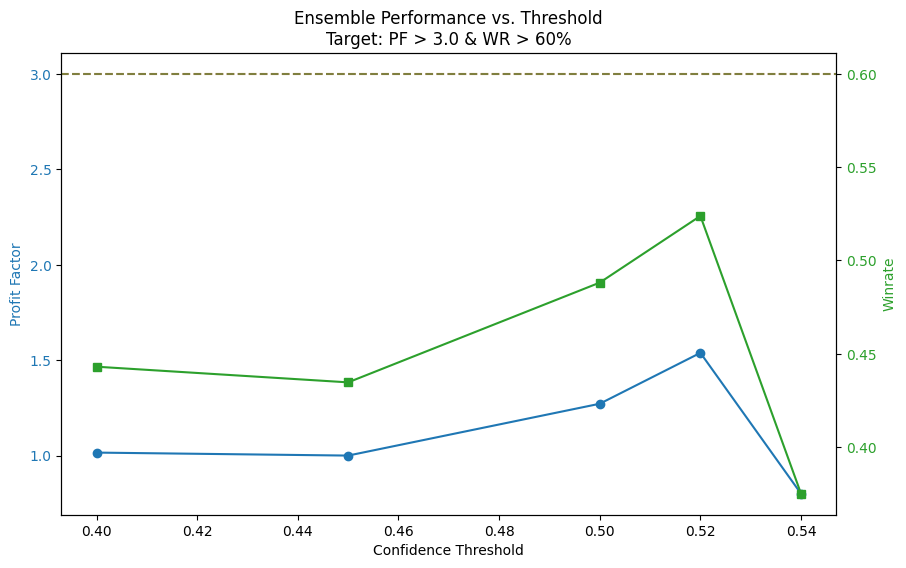


⚠️ No threshold explicitly met PF > 3 AND WR > 60% in this validation set.
Consider: 1) Increasing Training Data, 2) Adding Volatility Filter (Meta-Labeling), 3) Tuning Stop-Loss ratios.

Top Candidates by Profit Factor:
   Threshold  Trades   Winrate        PF
3       0.52      42  0.523810  1.537876
2       0.50      84  0.488095  1.271318
0       0.40    4521  0.443044  1.015415


In [9]:
# ===== 6) Recommendation & Plot =====
# Simple plot if matplotlib available
try:
    import matplotlib.pyplot as plt
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.set_xlabel('Confidence Threshold')
    ax1.set_ylabel('Profit Factor', color='tab:blue')
    ax1.plot(res_df['Threshold'], res_df['PF'], color='tab:blue', marker='o', label='Profit Factor')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.axhline(y=3.0, color='r', linestyle='--', alpha=0.5, label='Target PF=3.0')

    ax2 = ax1.twinx()  
    ax2.set_ylabel('Winrate', color='tab:green')
    ax2.plot(res_df['Threshold'], res_df['Winrate'], color='tab:green', marker='s', label='Winrate')
    ax2.tick_params(axis='y', labelcolor='tab:green')
    ax2.axhline(y=0.60, color='g', linestyle='--', alpha=0.5, label='Target WR=60%')

    plt.title("Ensemble Performance vs. Threshold\nTarget: PF > 3.0 & WR > 60%")
    plt.show()
except ImportError:
    print("Matplotlib not found, skipping plot.")

# Best Choice
best_row = res_df[(res_df["PF"] > 3.0) & (res_df["Winrate"] > 0.60)]
if not best_row.empty:
    print("\n✅ Recommended Thresholds (Meeting Goals):")
    print(best_row)
else:
    print("\n⚠️ No threshold explicitly met PF > 3 AND WR > 60% in this validation set.")
    print("Consider: 1) Increasing Training Data, 2) Adding Volatility Filter (Meta-Labeling), 3) Tuning Stop-Loss ratios.")
    # Show best sorted by PF
    print("\nTop Candidates by Profit Factor:")
    print(res_df.sort_values("PF", ascending=False).head(3))
